## Spatial trend maps 

This notebook displays maps of the spatial trends observed in the TIWP records.

In [1]:
from pathlib import Path 
import numpy as np 
import xarray as xr 
import matplotlib.pyplot as plt 
import matplotlib as mpl
import datetime
import pandas as pd 
import cartopy.crs as ccrs 
import cmocean
mpl.style.use("../../ccic.mplstyle") 

path = Path('/scratch/ccic_record/data')
mask = xr.open_dataset(path / 'mask_24.nc')

## Read in datasets

The code below reads in the datasets and subsamples very-high-resolution datasets to a resolution around 0.25 degree.

### MODIS 

In [2]:
modis = xr.open_dataset(path / 'processed' / 'modis_global_distribution_cf_tiwp_by_year.nc').rename(lat="latitude", lon="longitude")
modis_tiwp = modis.TIWP_global_distribution_unmasked / 1000
assert "year" in modis_tiwp.dims
assert "latitude" in modis_tiwp.dims
assert "longitude" in modis_tiwp.dims
assert modis_tiwp.year.min() > 2000

### PATMOS-x

In [4]:
# PATMOS-x 
patmos_ds = xr.open_dataset(path / 'PATMOS-x' / 'means' / 'PATMOS-x_timeseries198108-202106_notebook_results.nc')
mask_patmos = mask.interp(coords = {'longitude': patmos_ds.longitude.values, 'latitude': patmos_ds.latitude.values}, method = 'linear')
patmos_tiwp = patmos_ds.tiwp_yearly_mean / 1000

In [5]:
f_down = 10
n_time, n_lat, n_lon = patmos_tiwp.shape
patmos_tiwp_s = patmos_tiwp.data.reshape(n_time, n_lat // f_down, f_down, n_lon // f_down, f_down).mean((-3, -1))
patmos_tiwp = xr.DataArray(
    data = patmos_tiwp_s,
    coords = {
        "year": patmos_tiwp.year,
        "latitude": patmos_tiwp.latitude.data.reshape(n_lat // f_down, f_down).mean(-1),
        "longitude": patmos_tiwp.longitude.data.reshape(n_lon // f_down, f_down).mean(-1),
    }
)
assert "year" in patmos_tiwp.dims
assert "latitude" in patmos_tiwp.dims
assert "longitude" in patmos_tiwp.dims
assert patmos_tiwp.year.min() > 1980

### ERA5

In [6]:
era = xr.open_dataset(path / 'ERA5' / 'era5_tcsw_tciw_tcc_1980_2023_annualmeans.nc')
era_tiwp = era.tcsw[:,0,:,:]  + era.tciw[:,0,:,:] 
era_tiwp = era_tiwp.assign_coords({"longitude": np.where(era_tiwp.longitude < 180, era_tiwp.longitude, era_tiwp.longitude - 360)})
era_tiwp = era_tiwp.sortby("longitude")
era_tiwp = era_tiwp[{"latitude": slice(0, -1)}]
era_tiwp["year"] = era_tiwp.time.dt.year
valid_years = np.datetime64("1983-01-01") <= era_tiwp.time
era_tiwp = era_tiwp[{"time": valid_years}].swap_dims(time="year")

n_time, n_lat, n_lon = era_tiwp.shape

f_down = 4
era_tiwp_s = era_tiwp.data.reshape(n_time, n_lat // f_down, f_down, n_lon // f_down, f_down).mean((-3, -1))
era_tiwp = xr.DataArray(
    data = era_tiwp_s,
    coords = {
        "year": era_tiwp.year,
        "latitude": era_tiwp.latitude.data.reshape(n_lat // f_down, f_down).mean(-1),
        "longitude": era_tiwp.longitude.data.reshape(n_lon // f_down, f_down).mean(-1),
    }
)

assert "year" in era_tiwp.dims
assert "latitude" in era_tiwp.dims
assert "longitude" in era_tiwp.dims
assert era_tiwp.year.min() >= 1980

### CCIC (GridSat)

In [7]:
ccic_gridsat = xr.open_dataset( path / 'ccic' / 'gridsat' / 'ccic_gridsat_annualmean.nc') 
ccic_gridsat_tiwp = ccic_gridsat.tiwp 
#ccic_gridsat_tiwp = xr.concat([ccic_gridsat_tiwp, ccic_gridsat_tiwp[{"longitude": slice(0, 9)}]], dim="longitude")
#ccic_gridsat_tiwp.longitude.data[-9:] += 360 
ccic_gridsat_tiwp = ccic_gridsat_tiwp[{"longitude": slice(0, -3)}]

In [8]:
f_down = 20
n_time, n_lat, n_lon = ccic_gridsat_tiwp.shape
ccic_gridsat_tiwp_s = ccic_gridsat_tiwp.data.reshape(n_time, n_lat // f_down, f_down, n_lon // f_down, f_down).mean((-3, -1))
ccic_gridsat_tiwp = xr.DataArray(
    data = ccic_gridsat_tiwp_s,
    coords = {
        "year": ccic_gridsat_tiwp.month.dt.year.data,
        "latitude": ccic_gridsat_tiwp.latitude.data.reshape(n_lat // f_down, f_down).mean(-1),
        "longitude": ccic_gridsat_tiwp.longitude.data.reshape(n_lon // f_down, f_down).mean(-1),
    }
)
assert "year" in ccic_gridsat_tiwp.dims
assert "latitude" in ccic_gridsat_tiwp.dims
assert "longitude" in ccic_gridsat_tiwp.dims
assert ccic_gridsat_tiwp.year.min() >= 1980

### CCIC (CPCIR)

In [9]:
# CCIC CPCIR 
ccic_cpcir = xr.open_dataset(path / "processed" / "ccic_cpcir_tiwp_ca.nc")
ccic_cpcir_tiwp = ccic_cpcir.tiwp_yearly
ccic_cpcir_tiwp = xr.concat([ccic_cpcir_tiwp[{"latitude": slice(0, 11)}], ccic_cpcir_tiwp, ccic_cpcir_tiwp[{"latitude": slice(-12, -1)}]], dim="latitude")
ccic_cpcir_tiwp = ccic_cpcir_tiwp[{"longitude": slice(8, -8)}]

In [10]:
f_down = 40
n_time, n_lat, n_lon = ccic_cpcir_tiwp.shape
ccic_cpcir_tiwp_s = ccic_cpcir_tiwp.data.reshape(n_time, n_lat // f_down, f_down, n_lon // f_down, f_down).mean((-3, -1))
ccic_cpcir_tiwp = xr.DataArray(
    data = ccic_cpcir_tiwp_s,
    coords = {
        "year": ccic_cpcir_tiwp.year.data,
        "latitude": ccic_cpcir_tiwp.latitude.data.reshape(n_lat // f_down, f_down).mean(-1),
        "longitude": ccic_cpcir_tiwp.longitude.data.reshape(n_lon // f_down, f_down).mean(-1),
    }
)
assert "year" in ccic_cpcir_tiwp.dims
assert "latitude" in ccic_cpcir_tiwp.dims
assert "longitude" in ccic_cpcir_tiwp.dims
assert ccic_cpcir_tiwp.year.min() >= 1980

### ISCCP

In [11]:
# ISCCP 
isccp = path / 'processed' / 'isccp_tiwp_ca.nc'
isccp_ds = xr.open_dataset(isccp) 
isccp_tiwp = isccp_ds.tiwp_yearly

assert "year" in isccp_tiwp.dims
assert "latitude" in isccp_tiwp.dims
assert "longitude" in isccp_tiwp.dims
assert isccp_tiwp.year.min() >= 1980

### Common time period for trend 

In [12]:
# restrict to common time period 2003 - 2021
minyear = 2003
maxyear = 2023 

ccic_gridsat_tiwp_20 = ccic_gridsat_tiwp.where((ccic_gridsat_tiwp.year >= minyear) & (ccic_gridsat_tiwp.year <= maxyear), drop = True)
ccic_cpcir_tiwp_20 = ccic_cpcir_tiwp.where((ccic_cpcir_tiwp.year >= minyear) & (ccic_cpcir_tiwp.year <= maxyear), drop = True)
era_tiwp_20 = era_tiwp.where((era_tiwp.year >= minyear ) & (era_tiwp.year <= maxyear), drop = True) 
modis_tiwp_20 = modis_tiwp.where((modis_tiwp.year >= minyear ) & (modis_tiwp.year <= maxyear), drop = True)
patmos_tiwp_20 = patmos_tiwp.where((patmos_tiwp.year >= minyear) & (patmos_tiwp.year <= maxyear), drop = True) 
isccp_tiwp_20 = isccp_tiwp.where(( isccp_tiwp.year >= minyear) & ( isccp_tiwp.year <= maxyear), drop = True)

### Calculate spatial trends

In [13]:
from scipy.stats import t

def get_spatial_trend(data, normalize = False): 
    """
    Calculate decadal trends over a given time variable.

    Args:
        normalize: If 'True', the results are normalized using the grid-cell level mean.

    Return:
        A 2D np.ndarray containing the decadal trends.
    """
    data = data.transpose("year", ...)
    poly = data.polyfit("year", 1, skipna=True)
    intercept = poly.polyfit_coefficients.sel(degree=0).values
    slope = poly.polyfit_coefficients.sel(degree=1).values
    
    n = np.isfinite(data).sum("year").data
    years, _ = xr.broadcast(data.year, data)
    d_y = ((data - slope * years - intercept) ** 2).sum("year")
    rss = d_y.data
    x_var = ((years - years.mean("year")) ** 2).sum("year")
    se_m = np.sqrt(rss / (n - 2) / x_var.data)
    df = n - 2
    t_stat = slope / se_m
    p_value = 2.0 * (1 - t.cdf(np.abs(t_stat), df))
    
    if normalize is True: 
        slope = slope / np.maximum(data.mean("year").data, 0.01 * np.nanmean(data.data))
        
    return intercept, 10 * slope, p_value

In [14]:
# get slopes for FULL RECORD 
normalize = True
interc_ccic_gridsat, slope_ccic_gridsat, p_ccic_gridsat = get_spatial_trend(ccic_gridsat_tiwp, normalize = normalize)
interc_ccic_cpcir, slope_ccic_cpcir, p_ccic_cpcir = get_spatial_trend(ccic_cpcir_tiwp, normalize = normalize)
interc_era, slope_era, p_era = get_spatial_trend(era_tiwp, normalize = normalize)
interc_patmos, slope_patmos, p_patmos = get_spatial_trend(patmos_tiwp, normalize = normalize)
interc_modis, slope_modis, p_modis = get_spatial_trend(modis_tiwp, normalize = normalize)
interc_isccp, slope_isccp, p_isccp = get_spatial_trend(isccp_tiwp, normalize = normalize)

In [15]:
_, slope_ccic_gridsat_20, p_ccic_gridsat_20 = get_spatial_trend(ccic_gridsat_tiwp_20, normalize = normalize)
_, slope_ccic_cpcir_20, p_ccic_cpcir_20 = get_spatial_trend(ccic_cpcir_tiwp_20, normalize = normalize)
_, slope_era_20, p_era_20 = get_spatial_trend(era_tiwp_20, normalize = normalize)
_, slope_patmos_20, p_patmos_20 = get_spatial_trend(patmos_tiwp_20, normalize = normalize)
_, slope_modis_20, p_modis_20 = get_spatial_trend(modis_tiwp_20, normalize = normalize)
_, slope_isccp_20, p_isccp_20 = get_spatial_trend(isccp_tiwp_20, normalize = normalize)

## Verify p values

In [19]:
from scipy.stats import linregress

x = modis_tiwp_20.year.data
y = modis_tiwp_20.data[90, 180]

slope, intercept, r_value, p_value, std_err = linregress(x, y)
print(f"Slope: {slope}, P-value: {p_value}")

Slope: 0.00035894076166304484, P-value: 0.34527433605016356


## Plot spatial trend maps 

### 40-year trends

CCIC (GridSat) (100, 257)
PATMOS-x (180, 360)
ISCCP (180, 360)
ERA5 (180, 360)


/scratch/spfrnd/micromamba/envs/ccic_record/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1642: UserWarning: linewidths is ignored by contourf
  result = super().contourf(*args, **kwargs)
/tmp/ipykernel_1742079/4012747939.py:35: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in cntr.collections:
/scratch/spfrnd/micromamba/envs/ccic_record/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1642: UserWarning: linewidths is ignored by contourf
  result = super().contourf(*args, **kwargs)
/tmp/ipykernel_1742079/4012747939.py:35: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in cntr.collections:
/scratch/spfrnd/micromamba/envs/ccic_record/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1642: UserWarning: linewidths is ignored by contourf
  result = super().contourf(*args, **kwargs)
/tmp/ipykernel_1742079/4

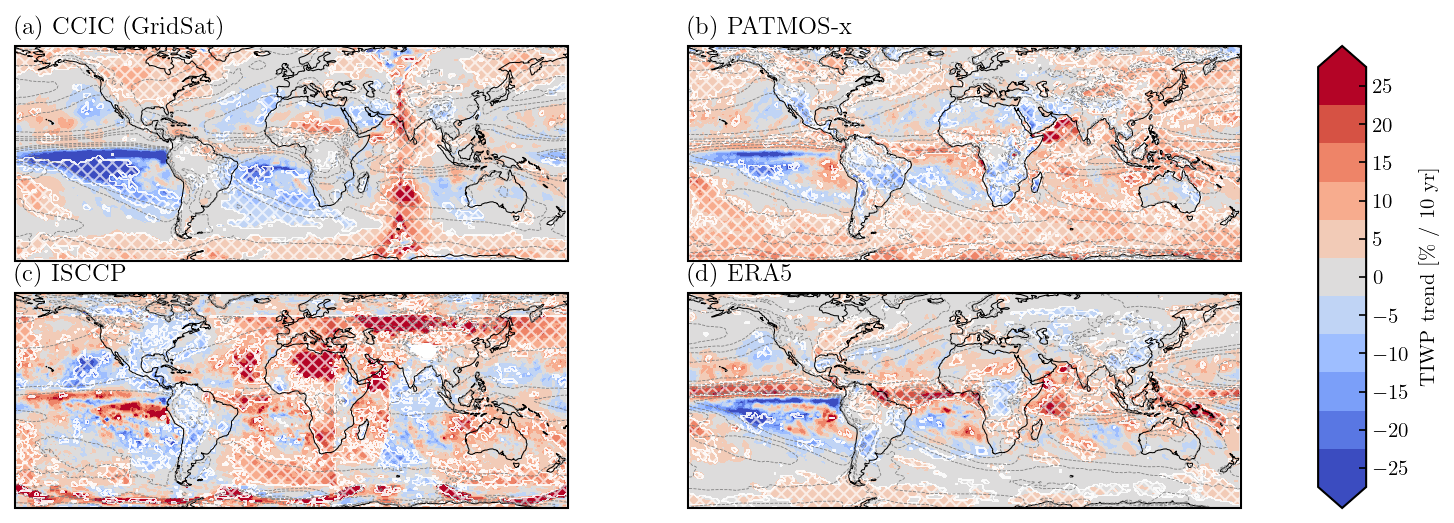

In [31]:
import cartopy.crs as ccrs
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
from matplotlib import colormaps

fig = plt.figure(figsize=(12, 4))
n_row = 2
n_col = 2
gs = GridSpec(n_row, n_col + 1, width_ratios=[1.0] * n_col + [0.075], hspace=0.15, wspace=0.075)
norm = Normalize(-25, 25)
cmap = colormaps["coolwarm"]

results = {
    "CCIC (GridSat)": (ccic_gridsat_tiwp.latitude, ccic_gridsat_tiwp.longitude, slope_ccic_gridsat, p_ccic_gridsat, ccic_gridsat_tiwp.mean("year")),
    "PATMOS-x": (patmos_tiwp.latitude, patmos_tiwp.longitude, slope_patmos, p_patmos, patmos_tiwp.mean("year")),
    "ISCCP": (isccp_tiwp.latitude, isccp_tiwp.longitude, slope_isccp, p_isccp, isccp_tiwp.mean("year")),
    "ERA5": (era_tiwp.latitude, era_tiwp.longitude, slope_era, p_era, era_tiwp.mean("year")),
}

for ind, (name, (lats, lons, res, p_val, tiwp)) in enumerate(results.items()):

    print(name, tiwp.shape)
    row_ind = ind // n_col
    col_ind = ind % n_col
    ax = fig.add_subplot(gs[row_ind, col_ind], projection=ccrs.PlateCarree())
    
    m = ax.contourf(lons, lats, 100 * res, norm=norm, cmap=cmap, levels=np.linspace(-27.5, 27.5, 12), extend="both")

    cntr_levels = np.linspace(0, 2, 5)[1:]
    cntr_styles = ["dotted", "dashdotted", "dashed", "solid"]
    ctrs = ax.contour(lons, lats, tiwp / tiwp.mean(), levels=cntr_levels, colors="grey", linestyles="--", linewidths=0.4)

    cntr = ax.contourf(lons, lats, p_val < 0.05, colors=["#FFFFFF00", "#FFFFFF00"], hatches=['', 'xxxx'], linewidths=0.2)
    for collection in cntr.collections:
        collection.set_edgecolor('#FFFFFFAA')  # Change to desired hatch color
        collection.set_linewidth(0.2)   
    
    ax.set_ylim(-70, 70)
    ax.set_xlim(-180, 180)

    ax.set_title(f"({chr(ord('a') + ind)}) {name}")

    if col_ind > 0:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel("Latitude [$^\circ$ N]")

    if row_ind < 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("Longitude [$^\circ$ W]")

    ax.coastlines()
    ax.grid(True)

cax = fig.add_subplot(gs[:, -1])
cb = plt.colorbar(m, cax=cax, label="TIWP trend [\% / 10 yr]")
cax.yaxis.set_ticks(np.arange(-25, 26, 5))
plt.show()
fig.savefig("../../figures/long_term_trends.png", bbox_inches="tight")

### 20-year trends

/scratch/spfrnd/micromamba/envs/ccic_record/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1642: UserWarning: linewidths is ignored by contourf
  result = super().contourf(*args, **kwargs)
/tmp/ipykernel_1742079/3644377749.py:35: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in cntr.collections:
/scratch/spfrnd/micromamba/envs/ccic_record/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1642: UserWarning: linewidths is ignored by contourf
  result = super().contourf(*args, **kwargs)
/tmp/ipykernel_1742079/3644377749.py:35: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in cntr.collections:
/scratch/spfrnd/micromamba/envs/ccic_record/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1642: UserWarning: linewidths is ignored by contourf
  result = super().contourf(*args, **kwargs)
/tmp/ipykernel_1742079/3

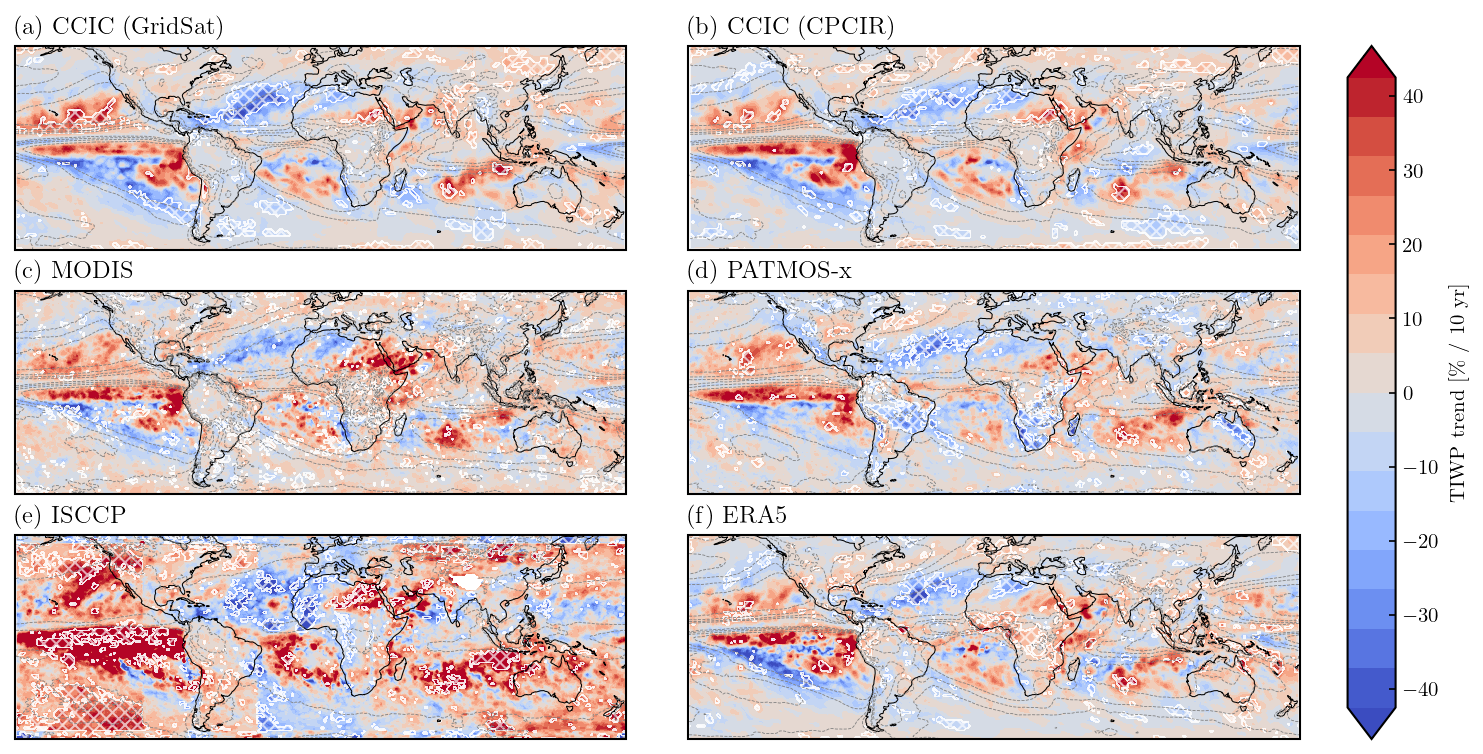

In [32]:
import cartopy.crs as ccrs
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
from matplotlib import colormaps

fig = plt.figure(figsize=(12, 6))
n_row = 3
n_col = 2
gs = GridSpec(n_row, n_col + 1, width_ratios=[1.0] * n_col + [0.075], wspace=0.075, hspace=0.2)
norm = Normalize(-42.5, 42.5)
cmap = colormaps["coolwarm"]

results = {
    "CCIC (GridSat)": (ccic_gridsat_tiwp.latitude, ccic_gridsat_tiwp.longitude, slope_ccic_gridsat_20, p_ccic_gridsat_20, ccic_gridsat_tiwp_20.mean("year")),
    "CCIC (CPCIR)": (ccic_cpcir_tiwp.latitude, ccic_cpcir_tiwp.longitude, slope_ccic_cpcir_20, p_ccic_cpcir_20, ccic_cpcir_tiwp_20.mean("year")),
    "MODIS": (modis_tiwp.latitude, modis_tiwp.longitude, slope_modis_20[::-1], p_modis_20, modis_tiwp_20.mean("year")[::-1]),
    "PATMOS-x": (patmos_tiwp.latitude, patmos_tiwp.longitude, slope_patmos_20, p_patmos_20, patmos_tiwp_20.mean("year")),
    "ISCCP": (isccp_tiwp.latitude, isccp_tiwp.longitude, slope_isccp_20, p_isccp_20, isccp_tiwp_20.mean("year")),
    "ERA5": (era_tiwp.latitude, era_tiwp.longitude, slope_era_20, p_era_20, era_tiwp_20.mean("year")),
}

for ind, (name, (lats, lons, res, p_val, tiwp)) in enumerate(results.items()):

    row_ind = ind // n_col
    col_ind = ind % n_col
    ax = fig.add_subplot(gs[row_ind, col_ind], projection=ccrs.PlateCarree())
    m = ax.contourf(lons, lats, 100 * res, norm=norm, cmap=cmap, levels=np.linspace(-42.5, 42.5, 17), extend="both")
    
    cntr_levels = np.linspace(0, 2, 5)[1:]
    cntr_styles = ["dotted", "dashdotted", "dashed", "solid"]
    ctrs = ax.contour(lons, lats, tiwp / tiwp.mean(), levels=np.linspace(0, 2, 5)[1:], colors="grey", linestyles="--", linewidths=0.4)
    
    
    cntr = ax.contourf(lons, lats, p_val < 0.05, colors=["#FFFFFF00", "#FFFFFF00"], hatches=['', 'xxxx'], linewidths=0.2)
    for collection in cntr.collections:
        collection.set_edgecolor('#FFFFFFAA')  # Change to desired hatch color
        collection.set_linewidth(0.2)   
        
    ax.set_ylim(-60, 60)
    ax.set_xlim(-180, 180)

    ax.set_title(f"({chr(ord('a') + ind)}) {name}")

    if col_ind > 0:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel("Latitude [$^\circ$ N]")

    if row_ind < 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("Longitude [$^\circ$ W]")

    ax.coastlines(color="k")
    ax.grid(True)

cax = fig.add_subplot(gs[:, -1])
plt.colorbar(m, cax=cax, label="TIWP trend [\% / 10 yr]")
cax.yaxis.set_ticks(np.arange(-40, 41, 10))

fig.savefig("../../figures/matched_trends.png", bbox_inches="tight")

In [222]:
lons.shape

(643,)

In [220]:
res.shape

(500, 1286)

### Zonal mean curves

In [22]:
import seaborn as sns
sns.reset_orig()

In [27]:
def calculate_masked_means(tiwp):
    mask_i = mask.interp(
        latitude=tiwp.latitude,
        longitude=tiwp.longitude,
        method="nearest",
        kwargs={"fill_value": False}
    )
    tiwp_masked = tiwp#tiwp.where(mask_i.mask)
    weights = np.cos(np.deg2rad(tiwp.latitude))
    weights[np.abs(tiwp.latitude) > 60] = 0.0
    return tiwp_masked.weighted(weights).mean('latitude'), tiwp_masked.mean('longitude')
    

In [28]:
tiwp_gridsat_masked = calculate_masked_means(ccic_gridsat_tiwp)

In [29]:
era_mm, era_zm = calculate_masked_means(era_tiwp)
ccic_gridsat_mm, ccic_gridsat_zm = calculate_masked_means(ccic_gridsat_tiwp)
isccp_mm, isccp_zm = calculate_masked_means(isccp_tiwp)
patmos_mm, patmos_zm = calculate_masked_means(patmos_tiwp)

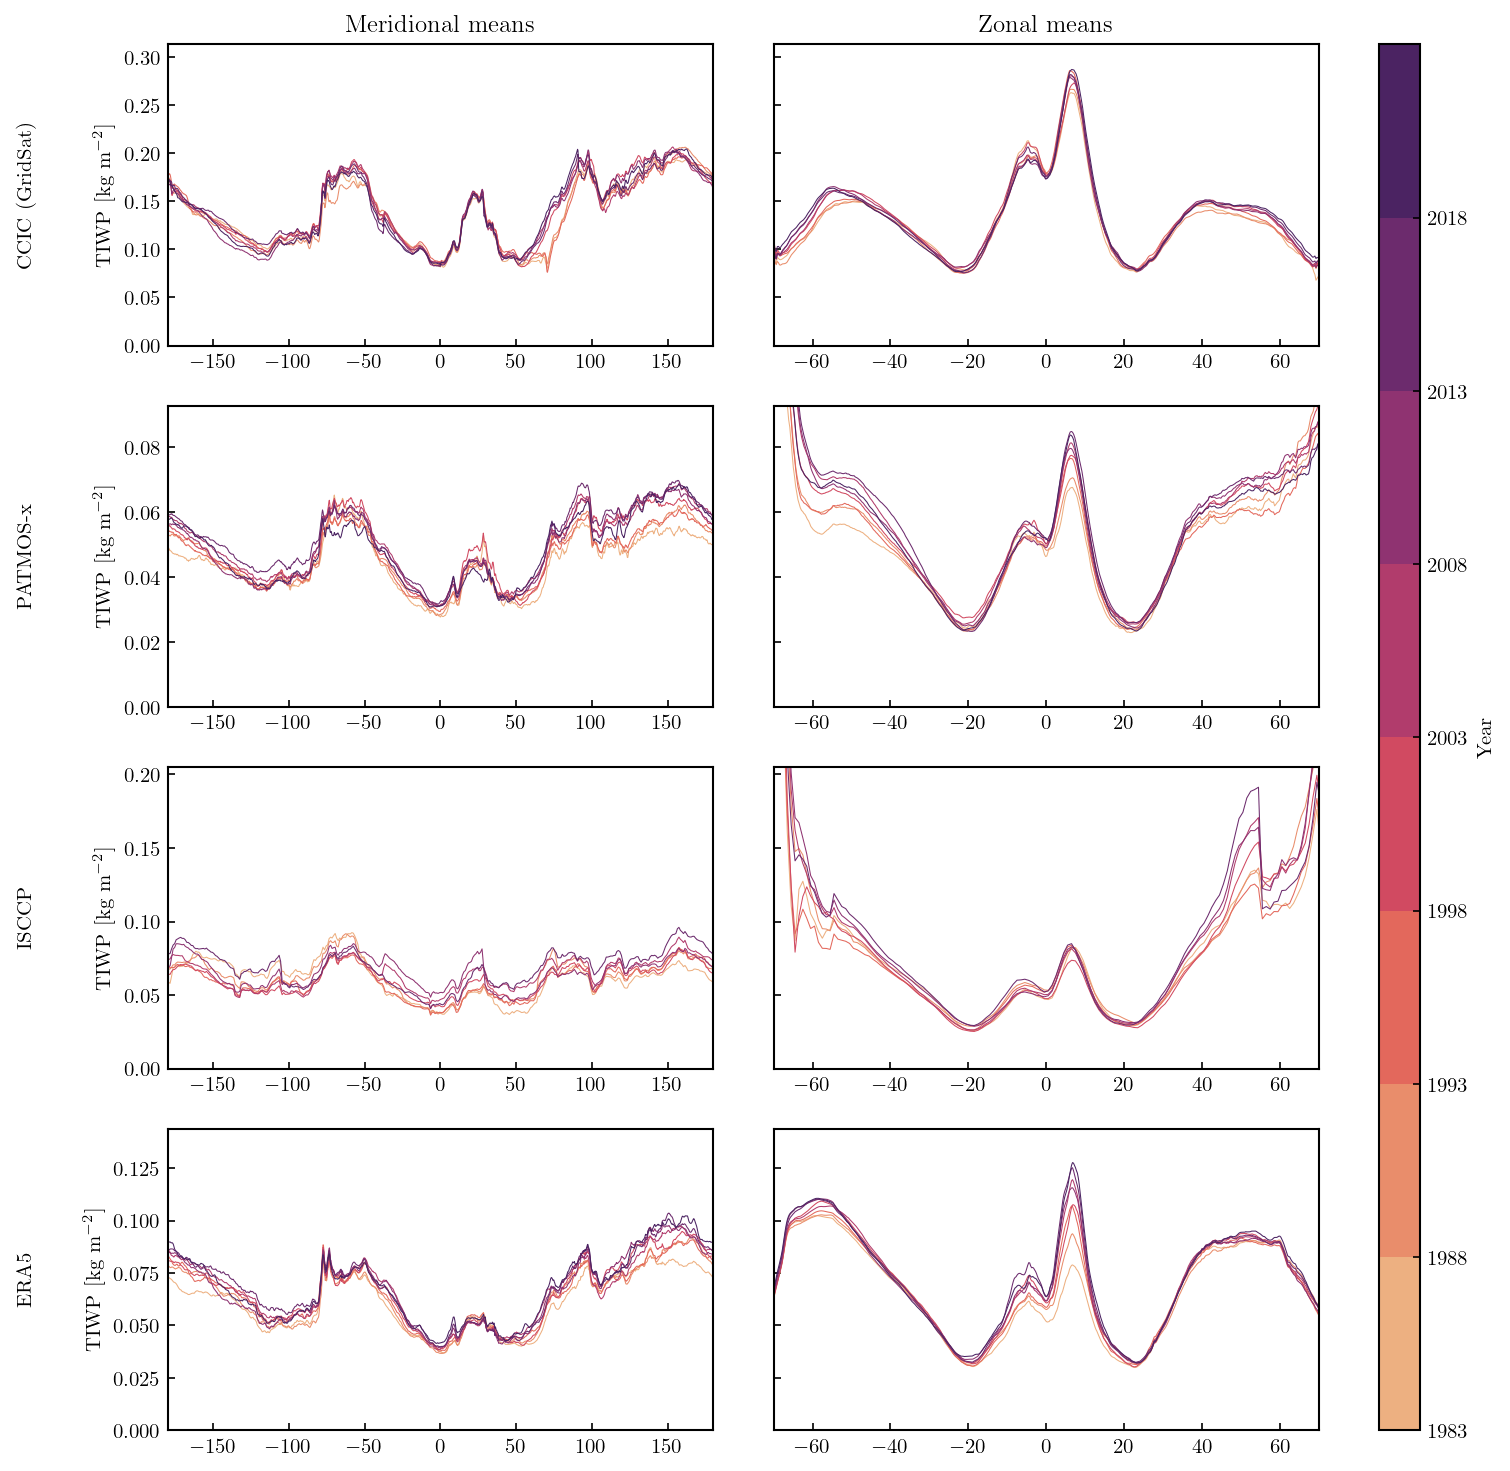

In [31]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import matplotlib.colors as mcolors
from matplotlib.colors import to_rgba

fig = plt.figure(figsize=(12, 12))
gs = GridSpec(4, 4, width_ratios=[0.15, 1.0, 1.0, 0.075])

cmap = ScalarMappable(cmap="flare", norm=Normalize(1980, 2020))

# Step 1: Choose a continuous colormap
continuous_cmap = plt.get_cmap('flare')

# Step 2: Discretize the colormap (e.g., 10 color segments)
num_bins = 8
colors = continuous_cmap(np.linspace(0, 1, num_bins))
segmented_cmap = mcolors.LinearSegmentedColormap.from_list('segmented_cmap', colors, N=num_bins)
cmap = ScalarMappable(norm=Normalize(1983, 2023), cmap=segmented_cmap)

interval = 5
years = np.arange(1983, 2023, interval)

datasets = {
    "CCIC (GridSat)": (ccic_gridsat_mm, ccic_gridsat_zm),
    "PATMOS-x": (patmos_mm, patmos_zm),
    "ISCCP": (isccp_mm, isccp_zm),
    "ERA5": (era_mm, era_zm),
}

for row_ind, (name, (mm, zm)) in enumerate(datasets.items()):
    
    ax = fig.add_subplot(gs[row_ind, 0])
    ax.set_axis_off()
    ax.text(0, 0, name, rotation=90, va="center", ha="center")
    ax.set_ylim(-2, 2)
    
    ax_mm = fig.add_subplot(gs[row_ind, 1])
    ax_zm = fig.add_subplot(gs[row_ind, 2])

    if row_ind == 0:
        ax_mm.set_title("Meridional means", loc="center")
        ax_zm.set_title("Zonal means", loc="center")

    lat_mask = (zm.latitude >= -60) * (zm.latitude <= 60)
    zm_max = zm[{"latitude": lat_mask}].max()
    
    for ind, year in enumerate(years):
        inds = (year <= mm.year) * (mm.year < year + interval)
        ax_mm.plot(mm.longitude, mm[{"year": inds}].mean("year"), c=cmap.to_rgba(year), lw=0.5)
        ax_mm.set_ylim(0, 1.0 * zm_max)
        ax_mm.set_xlim(-180, 180)
        
        ax_zm.plot(zm.latitude, zm[{"year": inds}].mean("year"), c=cmap.to_rgba(year), lw=0.5)
        ax_zm.set_ylim(0, 1.0 * zm_max)
        ax_zm.set_xlim(-70, 70)

    ax_zm.set_yticklabels([])
    ax_mm.set_ylabel("TIWP [kg m$^{-2}$]")

ax = fig.add_subplot(gs[:, -1])
plt.colorbar(cmap, label="Year", cax=ax)
ax.yaxis.set_ticks(years)
fig.savefig("../../figures/trends_zonal_meridional.pdf", bbox_inches="tight")